In [ ]:
!pip install tensorflow
import tensorflow as tf
tf.__version__

'2.15.0'

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import VGG16
import matplotlib.pyplot as plt

In [ ]:
IMAGE_SIZE = 300
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 20

In [ ]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/Colab Notebooks/rice_img',
    shuffle=True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 4347 files belonging to 3 classes.


In [ ]:
class_names=dataset.class_names
class_names

['Bacterialblight', 'Blast', 'Tungro']

In [ ]:
#how many images per batch
len(dataset)

136

(32, 300, 300, 3)
[2 0 0 1 2 2 1 2 0 1 0 1 1 1 1 0 0 0 2 2 1 1 2 0 0 0 0 2 0 2 0 1]


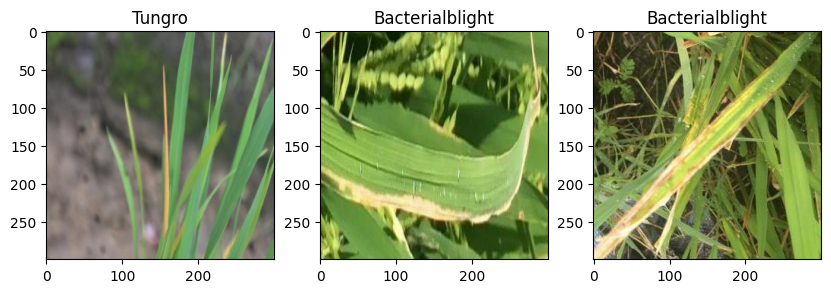

In [ ]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):

    #show batch size,image size,rgb channel
    print(image_batch.shape)

    #show classes
    print(label_batch.numpy())

    #show image of the first data
    for i in range(3):
        ax=plt.subplot(1,3,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])

In [ ]:
def dataset_split_tf(ds,train_split=0.75,val_split=0.15,test_split=0.15,shuffle=True,shuffle_size=10000):

    ds_size=len(ds)

    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)

    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)

    train_ds=ds.take(train_size)

    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)

    return train_ds,val_ds,test_ds

In [ ]:
train_ds,val_ds,test_ds =dataset_split_tf(dataset)

In [ ]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))


58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
base_model.trainable = False

In [ ]:
 input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),  # Additional dense layer
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),  # Additional dense layer
    layers.Dropout(0.4),  # Additional dropout layer
    layers.Dense(128, activation='relu'),  # Additional dense layer
    layers.Dropout(0.3),  # Additional dropout layer
    layers.Flatten(),
    layers.Dense(64, activation='relu'),  # Additional dense layer
    layers.Dropout(0.2),  # Additional dropout layer
    layers.Dense(n_classes, activation='softmax')
])


model.build(input_shape=(None,) + input_shape)





In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 9, 9, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                        

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history=model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/20
 16/102 [===>..........................] - ETA: 49:22 - loss: 1.6577 - accuracy: 0.4398

KeyboardInterrupt: 

In [ ]:
scores=model.evaluate(test_ds)#first parameter is loss, 2nd parameter is accuracy
print("Test Loss:", scores[0])
print("Test Accuracy:", scores[1])

14/14 [==============================] - 506s 34s/step - loss: 0.6960 - accuracy: 0.7232
Test Loss: 0.6959548592567444
Test Accuracy: 0.7232142686843872


In [ ]:
history.params
history.history.keys()
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']


In [ ]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label='Training Accuracy')
plt.plot(range(EPOCHS),val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss,label='Training Loss')
plt.plot(range(EPOCHS),val_loss,label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
#prediction
import numpy as np
for images_batch, label_batch in test_ds.take(1):

    first_image=images_batch[0].numpy().astype('uint8')
    first_label=label_batch[0]

    print("First image to predict")
    plt.imshow(first_image)
    print("First image's actual label:",class_names [first_label])
    batch_prediction=model.predict(images_batch)
    print("Predicted Label:",class_names[np.argmax(batch_prediction[0])] )#will show three nueron n_classes parameters

In [ ]:
def prediction(model,img):
    img_array= tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    #create a batch
    img_array=tf.expand_dims(img_array,0)
    predictions=model.predict(img_array)
    predicted_class=class_names[np.argmax(predictions[0])]
    confidence=round(100*(np.max(predictions[0])),2)
    return predicted_class,confidence

In [ ]:
plt.figure(figsize=(10,10))
for images,labels in test_ds.take(1):
    for i in range(3):
        ax=plt.subplot(1,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class,confidence=prediction(model,images[i].numpy())
        actual_class=class_names[labels[i]]
        plt.title(f"Actual:{actual_class},\n Predicted Class:{predicted_class}")